This cell defines the experiment’s parameters in one place (time horizon, prior, success rate, prize, cost, discovery probability, training knobs) and a few tiny helper functions. It also provides closed-form benchmark functions for the think frequency under T=2 and for the T=3 “Option A” variant. You’ll use these to plot the theoretical curves next to the learned behavior.

In [11]:
# bandit_selfplay.py
from __future__ import annotations
import numpy as np
from dataclasses import dataclass, asdict
from typing import Tuple, Dict, List
import random, math, csv, os
import matplotlib.pyplot as plt

# -----------------------------
# Config
# -----------------------------
@dataclass
class Config:
    # core primitives
    T: int = 2                # 2 or 3 (Option A uses T=3)
    p: float = 0.60           # prior that the left arm is good (exactly one arm is good)
    lam: float = 0.70         # success prob when good arm is pulled
    V: float = 1.0            # prize value
    c: float = 0.10           # thinking cost
    r: float = 0.40           # breakthrough prob
    # rules
    exclusivity: bool = True  # exclusivity/sharing rule active
    option_A: bool = False    # if T=3, exclusivity applies to both t=2 and t=3 when True
    # RL
    episodes: int = 300_000
    seed: int = 0
    eps_start: float = 0.12
    eps_end: float = 0.02
    eps_decay: float = 0.999995    # slow decay; tuned so Think gets sampled
    alpha: float = 0.15           # learning rate (single-step problem, gamma is 0)
    optimistic_init: float = 0.03  # mild optimistic bump for Think
    # logging / plots
    outdir: str = "out"
    show_plots: bool = True
    save_plots: bool = True
    rolling_window: int = 12_000   # for smoothing the final frequency
    eval_every: int = 5_000

# -----------------------------
# Theory helpers
# -----------------------------
def Lambda(p: float, r: float, lam: float, V: float) -> float:
    """Continuation value with one period left for a thinker (before cost)."""
    return lam * V * (r + (1 - r) * p)

def clip01(x: float) -> float:
    return max(0.0, min(1.0, x))

def theory_think_freq_T2(p: float, r: float, lam: float, V: float, c: float) -> float:
    """
    T = 2: symmetric mixed equilibrium Think frequency 1 - x* where
    x* = 2 (p λ V + c)/Λ(p) - 1, clipped to [0, 1].
    """
    L = Lambda(p, r, lam, V)
    if L <= 0:
        return 0.0
    x_do = (2.0 * (p * lam * V + c) / L) - 1.0
    return clip01(1.0 - clip01(x_do))

def theory_think_freq_T3_OptionA(p: float, r: float, lam: float, V: float, c: float) -> float:
    """
    T = 3, Option A (exclusivity persists to both t=2 and t=3):
    x* = [ c - (Λ - p λ V) ] / [ Λ - 0.5 p λ V ], then Think freq = 1 - x*, clipped.
    (Baseline T=3 without Option A coincides with T=2.)
    """
    L = Lambda(p, r, lam, V)
    denom = L - 0.5 * p * lam * V
    if denom <= 1e-12:
        return 0.0
    x_do = (c - (L - p * lam * V)) / denom
    return clip01(1.0 - clip01(x_do))


This cell encodes the game itself. At the single decision step both players choose Do or Think. Do may yield an immediate prize with probability equal to success rate times prior and is split if both Do. Think pays the cost and may reveal the good arm privately; if both Think, a single shared discovery flag is drawn. Rights for later periods are none, exclusive to one thinker, or shared. Later-period success uses the higher success rate if someone knows the good arm, otherwise the baseline chance; payoffs are allocated by the rights rule. The episode returns both players’ total rewards and a small info dictionary.

In [12]:
# -----------------------------
# Environment
# -----------------------------
# Actions
DO, THINK = 0, 1

class TwoPlayerBanditEnv:
    """
    One decision stage at t=1: each agent chooses {Do, Think}.
    Later periods are forced exploitation with single shared success per period.
    Private breakthroughs; recipients determined by exclusivity/share rule.
    """
    def __init__(self, cfg: Config):
        self.cfg = cfg
        self.rng = random.Random(cfg.seed)
        np.random.seed(cfg.seed)

    def reset(self):
        # No observable state is needed; decision only at t=1
        return 0, 0  # dummy observations

    def run_episode(self, a0: int, a1: int) -> Tuple[float, float, Dict]:
        c = self.cfg.c
        r = self.cfg.r
        lam = self.cfg.lam
        V = self.cfg.V
        p = self.cfg.p
        T = self.cfg.T
        option_A = self.cfg.option_A
        # bookkeeping
        R0 = 0.0
        R1 = 0.0

        # t = 1 decisions: pay costs and draw private breakthroughs for thinkers
        b0 = 0
        b1 = 0
        if a0 == THINK:
            R0 -= c
            b0 = 1 if self.rng.random() < r else 0
        if a1 == THINK:
            R1 -= c
            b1 = 1 if self.rng.random() < r else 0

        # period-1 exploitation if any Do at t=1
        if (a0 == DO) or (a1 == DO):
            # shared success event with probability λ * p (no knowledge at t=1)
            success = 1 if self.rng.random() < (lam * p) else 0
            if success:
                if (a0 == DO) and (a1 == DO):
                    R0 += 0.5 * V
                    R1 += 0.5 * V
                elif a0 == DO:
                    R0 += V
                else:
                    R1 += V

        # rights for period-2 (and period-3 if Option A)
        # none -> contested split; exactly one thinker -> exclusive owner; both -> shared
        if (a0 == THINK) and (a1 == THINK):
            rights = "shared"
            # IMPORTANT: one virtual discovery draw behind the shared right; reuse later (Option A)
            K_shared = 1 if self.rng.random() < r else 0
        elif (a0 == THINK) ^ (a1 == THINK):
            rights = "exclusive0" if (a0 == THINK) else "exclusive1"
            K_shared = None
        else:
            rights = "none"
            K_shared = None

        # helper: success probability in a later period (uses knowledge flags correctly)
        def period_success_prob():
            # if someone knows the good arm: q = λ; else q = λ p
            if rights == "shared":
                return lam if K_shared == 1 else lam * p
            elif rights == "exclusive0":
                return lam if b0 == 1 else lam * p
            elif rights == "exclusive1":
                return lam if b1 == 1 else lam * p
            else:  # "none"
                return lam * p

        # period 2
        q2 = period_success_prob()
        succ2 = 1 if self.rng.random() < q2 else 0
        if succ2:
            if rights == "shared" or rights == "none":
                R0 += 0.5 * V
                R1 += 0.5 * V
            elif rights == "exclusive0":
                R0 += V
            elif rights == "exclusive1":
                R1 += V

        # period 3 (only under Option A with T=3)
        if (T == 3) and option_A:
            q3 = period_success_prob()  # same K_shared or same b_i reused
            succ3 = 1 if self.rng.random() < q3 else 0
            if succ3:
                if rights == "shared" or rights == "none":
                    R0 += 0.5 * V
                    R1 += 0.5 * V
                elif rights == "exclusive0":
                    R0 += V
                elif rights == "exclusive1":
                    R1 += V

        info = {
            "a0": a0, "a1": a1,
            "b0": b0, "b1": b1,
            "rights": rights
        }
        return R0, R1, info


This cell implements simple tabular Double Q-learning for a one-step task. There’s one state and two actions, with a small optimistic bump on Think so it gets tried. The policy is epsilon-greedy. Updates use the realized reward directly since there are no future steps to back up. Epsilon decays slowly to keep enough exploration early on.

In [13]:
# -----------------------------
# Double Q-learner (tabular)
# -----------------------------
class DoubleQLearner:
    def __init__(self, cfg: Config, seed: int):
        self.cfg = cfg
        self.rng = random.Random(seed)
        # single state (index 0), two actions
        self.Q1 = np.zeros((1, 2), dtype=np.float64)
        self.Q2 = np.zeros((1, 2), dtype=np.float64)
        # mild optimistic init for THINK to ensure it's tried
        self.Q1[0, THINK] += cfg.optimistic_init
        self.Q2[0, THINK] += cfg.optimistic_init
        self.eps = cfg.eps_start

    def policy(self) -> int:
        if self.rng.random() < self.eps:
            return self.rng.choice([DO, THINK])
        q_mean = (self.Q1[0] + self.Q2[0]) * 0.5
        # tie-break randomly
        if abs(q_mean[DO] - q_mean[THINK]) < 1e-12:
            return self.rng.choice([DO, THINK])
        return int(np.argmax(q_mean))

    def learn(self, a: int, r: float):
        # single-step episode -> gamma = 0, so target is just r
        alpha = self.cfg.alpha
        if self.rng.random() < 0.5:
            # update Q1 with Q2 bootstrap (classic Double Q; gamma=0 so bootstrapping term drops)
            self.Q1[0, a] += alpha * (r - self.Q1[0, a])
        else:
            self.Q2[0, a] += alpha * (r - self.Q2[0, a])

    def decay_eps(self):
        self.eps = max(self.cfg.eps_end, self.eps * self.cfg.eps_decay)


This cell wires the pieces together. It includes utilities for warm-starting Q-tables across nearby grid points and a greedy action reader for early stopping. Training runs two learners in self-play and stops once their greedy choices stabilize. A separate evaluator estimates the final think rate with exploration turned off. Averages over multiple seeds reduce variance. Finally, sweep functions generate the figures and CSVs: T=2 versus discovery probability, T=2 versus cost, and T=3 Option A versus discovery probability, with theory overlays.

In [17]:
# -----------------------------
# Training / evaluation  — EARLY-STOP + WARM-START
# -----------------------------

def dataclass_replace(cfg: Config, **kwargs) -> Config:
    d = asdict(cfg); d.update(kwargs); return Config(**d)

def _set_init_Q(learner, Q1: np.ndarray, Q2: np.ndarray):
    """Warm-start helper: copy Q-tables into a learner (shape (1,2))."""
    if Q1 is not None and Q2 is not None:
        learner.Q1[...] = Q1
        learner.Q2[...] = Q2

def _greedy_action_from_Q(learner) -> int:
    q = (learner.Q1[0] + learner.Q2[0]) * 0.5
    if abs(q[0] - q[1]) < 1e-12:  # fair tie-break
        return random.choice([0, 1])
    return int(np.argmax(q))

def evaluate_greedy_think_freq(env: TwoPlayerBanditEnv,
                               A: "DoubleQLearner",
                               B: "DoubleQLearner",
                               episodes: int = 150_000) -> float:
    """ε=0 evaluation of the converged policy."""
    think = 0
    for _ in range(episodes):
        env.reset()
        a0 = _greedy_action_from_Q(A)
        a1 = _greedy_action_from_Q(B)
        env.run_episode(a0, a1)
        think += (a0 == THINK) + (a1 == THINK)
    return think / (2 * episodes)

def train_self_play(cfg: Config,
                    init_Q: tuple | None = None,
                    max_episodes: int | None = None,
                    eval_after: int = 150_000,
                    check_every: int = 40_000,
                    patience_checks: int = 3) -> tuple[float, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Train two Double-Q learners, optional warm start, early-stop once greedy
    actions stabilize. Returns (greedy_freq, A.Q1, A.Q2, B.Q1, B.Q2).
    """
    if max_episodes is None: max_episodes = cfg.episodes

    env = TwoPlayerBanditEnv(cfg)
    A = DoubleQLearner(cfg, seed=cfg.seed)
    B = DoubleQLearner(cfg, seed=cfg.seed + 1)

    # Warm-start from previous grid point
    if init_Q is not None:
        QA1, QA2, QB1, QB2 = init_Q
        _set_init_Q(A, QA1, QA2)
        _set_init_Q(B, QB1, QB2)

    # TRAIN with early stop
    last_greedy = []
    for ep in range(1, max_episodes + 1):
        env.reset()
        a0 = A.policy(); a1 = B.policy()
        R0, R1, _ = env.run_episode(a0, a1)
        A.learn(a0, R0); B.learn(a1, R1)
        A.decay_eps(); B.decay_eps()   # keep your learner's epsilon decay

        if ep >= eval_after and (ep - eval_after) % check_every == 0:
            g0 = _greedy_action_from_Q(A)
            g1 = _greedy_action_from_Q(B)
            last_greedy.append((g0, g1))
            if len(last_greedy) >= patience_checks and len(set(last_greedy[-patience_checks:])) == 1:
                break

    greedy_freq = evaluate_greedy_think_freq(TwoPlayerBanditEnv(cfg), A, B, episodes=150_000)
    return greedy_freq, A.Q1.copy(), A.Q2.copy(), B.Q1.copy(), B.Q2.copy()

def avg_over_seeds_with_warmstart(make_cfg_for_point,
                                  grid_values,
                                  base_cfg: Config,
                                  seeds=(0, 17, 39, 71),
                                  # default training knobs for T=2 sweeps
                                  max_episodes=500_000,
                                  eval_after=150_000,
                                  check_every=40_000,
                                  patience_checks=3) -> list[float]:
    """
    Sweep over grid_values with warm-start per seed. make_cfg_for_point(cfg, v)
    returns a cfg with v applied (e.g., r or c). Returns mean greedy Think freq.
    """
    means = []
    seed_state = {s: None for s in seeds}  # seed -> (QA1,QA2,QB1,QB2)
    for v in grid_values:
        per_seed = []
        for s in seeds:
            cfg = dataclass_replace(base_cfg, seed=s, optimistic_init=0.01)
            cfg = make_cfg_for_point(cfg, float(v))
            val, QA1, QA2, QB1, QB2 = train_self_play(
                cfg,
                init_Q=seed_state[s],
                max_episodes=max_episodes,
                eval_after=eval_after,
                check_every=check_every,
                patience_checks=patience_checks
            )
            per_seed.append(val)
            seed_state[s] = (QA1, QA2, QB1, QB2)
        means.append(float(np.mean(per_seed)))
    return means

# -----------------------------
# Sweeps and plots — T=2: r-sweep and c-sweep
# -----------------------------
def ensure_dir(path: str):
    if not os.path.isdir(path): os.makedirs(path, exist_ok=True)

def sweep_vs_r_and_plot(baseline: Config):
    ensure_dir(baseline.outdir)
    rs = np.linspace(0.05, 0.95, 19)

    def set_r(cfg, rval): return dataclass_replace(cfg, r=rval)

    learned = avg_over_seeds_with_warmstart(set_r, rs, baseline, seeds=(0,17,39,71))
    theory  = [theory_think_freq_T2(baseline.p, float(r), baseline.lam, baseline.V, baseline.c) for r in rs]

    # CSV
    csv_path = os.path.join(baseline.outdir, f"T{baseline.T}_think_vs_r.csv")
    with open(csv_path, "w", newline="") as f:
        w = csv.writer(f); w.writerow(["r","learned_think_freq","theory_think_freq_T2"])
        for r, L, T2 in zip(rs, learned, theory): w.writerow([f"{r:.5f}", f"{L:.6f}", f"{T2:.6f}"])

    # Plot
    plt.figure(figsize=(6.2,4.4))
    plt.plot(rs, learned, label="Self-play (avg over seeds, warm-start)")
    plt.plot(rs, theory, "--", label="Theory (T=2)")
    plt.xlabel("breakthrough probability r"); plt.ylabel("Think frequency at t=1")
    plt.title(f"T={baseline.T}: Think frequency vs r  (c fixed at {baseline.c})")
    plt.ylim(-0.02,1.02); plt.legend()
    if baseline.save_plots: plt.savefig(os.path.join(baseline.outdir, f"T{baseline.T}_think_vs_r.png"), dpi=160, bbox_inches="tight")
    if baseline.show_plots: plt.show()
    else: plt.close()

def sweep_vs_c_and_plot(baseline: Config):
    ensure_dir(baseline.outdir)
    cs = np.linspace(0.0, 0.35, 18)

    def set_c(cfg, cval): return dataclass_replace(cfg, c=cval)

    learned = avg_over_seeds_with_warmstart(set_c, cs, baseline, seeds=(0,17,39,71))
    theory  = [theory_think_freq_T2(baseline.p, baseline.r, baseline.lam, baseline.V, float(c)) for c in cs]

    csv_path = os.path.join(baseline.outdir, f"T{baseline.T}_think_vs_c.csv")
    with open(csv_path, "w", newline="") as f:
        w = csv.writer(f); w.writerow(["c","learned_think_freq","theory_think_freq_T2"])
        for c, L, T2 in zip(cs, learned, theory): w.writerow([f"{c:.5f}", f"{L:.6f}", f"{T2:.6f}"])

    plt.figure(figsize=(6.2,4.4))
    plt.plot(cs, learned, label="Self-play (avg over seeds, warm-start)")
    plt.plot(cs, theory, "--", label="Theory (T=2)")
    plt.xlabel("thinking cost c"); plt.ylabel("Think frequency at t=1")
    plt.title(f"T={baseline.T}: Think frequency vs c  (r fixed at {baseline.r})")
    plt.ylim(-0.02,1.02); plt.legend()
    if baseline.save_plots: plt.savefig(os.path.join(baseline.outdir, f"T{baseline.T}_think_vs_c.png"), dpi=160, bbox_inches="tight")
    if baseline.show_plots: plt.show()
    else: plt.close()

# -----------------------------
# Sweep and plot — T=3 Option A (stronger exploration for delayed rewards)
# -----------------------------
def sweep_optionA_vs_r_and_plot(baseline_T3: Config):
    """
    T=3, Option A sweep with a slightly stronger exploration/optimism schedule
    to avoid under-sampling THINK (delayed payoff across two periods).
    """
    ensure_dir(baseline_T3.outdir)
    rs = np.linspace(0.05, 0.95, 19)

    def set_r_and_boost(cfg, rval):
        return dataclass_replace(
            cfg,
            r=rval,
            episodes=800_000,     # a bit more training than T=2
            optimistic_init=0.03, # nudge THINK to be sampled
            eps_start=0.15,       # stronger exploration
            eps_end=0.02,
            eps_decay=0.999997,   # slower decay
            alpha=0.20            # snappier updates for delayed rewards
        )

    # Use the same warm-start machinery but with Option-A overrides
    learned = avg_over_seeds_with_warmstart(
        set_r_and_boost, rs, baseline_T3, seeds=(0,17,39,71),
        max_episodes=650_000, eval_after=180_000, check_every=50_000, patience_checks=3
    )

    theoryA = [theory_think_freq_T3_OptionA(baseline_T3.p, float(r), baseline_T3.lam, baseline_T3.V, baseline_T3.c) for r in rs]
    theoryT2 = [theory_think_freq_T2(baseline_T3.p, float(r), baseline_T3.lam, baseline_T3.V, baseline_T3.c) for r in rs]

    csv_path = os.path.join(baseline_T3.outdir, "T3_OptionA_think_vs_r.csv")
    with open(csv_path, "w", newline="") as f:
        w = csv.writer(f); w.writerow(["r","learned_think_freq","theory_T2","theory_T3_OptionA"])
        for r, L, T2v, TA in zip(rs, learned, theoryT2, theoryA):
            w.writerow([f"{r:.5f}", f"{L:.6f}", f"{T2v:.6f}", f"{TA:.6f}"])

    plt.figure(figsize=(6.2,4.4))
    plt.plot(rs, learned, label="Self-play (avg over seeds, warm-start)")
    plt.plot(rs, theoryT2, "--", label="Theory T=2 (baseline)")
    plt.plot(rs, theoryA, ":", label="Theory T=3 Option A")
    plt.xlabel("breakthrough probability r"); plt.ylabel("Think frequency at t=1")
    plt.title("T=3 Option A: Think frequency vs r  (c fixed)")
    plt.ylim(-0.02,1.02); plt.legend()
    if baseline_T3.save_plots: plt.savefig(os.path.join(baseline_T3.outdir, "T3_OptionA_think_vs_r.png"), dpi=160, bbox_inches="tight")
    if baseline_T3.show_plots: plt.show()
    else: plt.close()



This cell sets a baseline configuration aligned with the thesis and runs the three sweeps. It saves clean CSVs and PNGs in output folders and optionally shows the plots. Running this cell reproduces the results and figures referenced in the write-up.

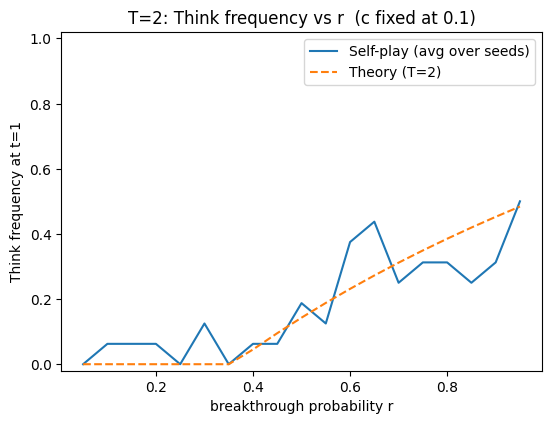

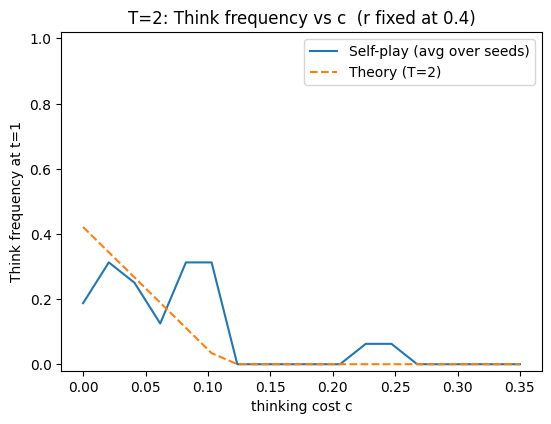

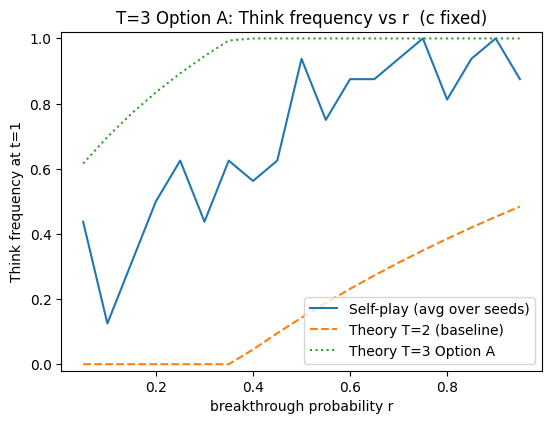

In [16]:
# -----------------------------
# Main
# -----------------------------
if __name__ == "__main__":
    # Baseline calibration from your doc: p=0.6, λ=0.7, V=1, c=0.10, r=0.40
    base = Config(
        T=2, p=0.60, lam=0.70, V=1.0, c=0.10, r=0.40,
        exclusivity=True, option_A=False,
        episodes=320_000,    # 300k+ as you wanted; bump a bit for smoother curves
        eps_start=0.12, eps_end=0.02, eps_decay=0.999995,
        alpha=0.20, optimistic_init=0.03,
        outdir="out_T2",
        show_plots=True, save_plots=True,
        rolling_window=12_000, eval_every=5_000, seed=0
    )

    # 1) T=2: Think frequency vs r (cost fixed)
    sweep_vs_r_and_plot(base)

    # 2) T=2: Think frequency vs c (r fixed)
    sweep_vs_c_and_plot(base)

    # 3) T=3 Option A: Think frequency vs r
    base_T3A = dataclass_replace(
        base,
        T=3, option_A=True, outdir="out_T3A"
    )
    sweep_optionA_vs_r_and_plot(base_T3A)
